# Imports and Custom Functions

In [154]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from matplotlib.pyplot import figure
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from scipy import stats

In [2]:
def remove_zeros_distribution(X):

    return [i for i in X if i != 0]

def log_binning_distribution(x_i,B = 20): 
    
    x_i = remove_zeros_distribution(x_i)

    b_1 = min(x_i)
    b_Bp1 = max(x_i)
    q_1 = np.log(b_1)
    q_Bp1 = np.log(b_Bp1)
    D_q = q_Bp1 - q_1
    L_q = D_q / B

    q_list = []
    b_list = []

    for i in range(B):
        j = i + 1
        q_list.append(q_1 + (j-1)*L_q)
        b_list.append(np.exp(q_1 + (j-1)*L_q))

    # b_list.insert(0,b_1)
    # b_list.append(b_Bp1)
    
    binned_x_i = []
    density_list = []

    for i in range(len(b_list)-1):
        bin_low = b_list[i]
        bin_high = b_list[i+1]
        count_bin = 0
        for j in range(len(x_i)):
            if x_i[j] >= bin_low and x_i[j] < bin_high:
                count_bin = count_bin + 1
                
        if count_bin > 0:
            density_bin = count_bin / (len(x_i)*(bin_high-bin_low))
            density_list.append(density_bin)
            binned_x_i.append(bin_low)
        else:
            continue 
            
    return binned_x_i, density_list

# Randomizing Layer 1

In [3]:
train = pd.read_csv('../data/Transformer_CNN_train_fold2.csv')
val = pd.read_csv('../data/Transformer_CNN_val_fold2.csv')
test = pd.read_csv('../data/Transformer_CNN_test_fold2.csv')

In [4]:
all_data = pd.concat([train,val,test])

In [5]:
#network_derived = pd.read_csv('/data/sars-busters-consolidated/GitData/interactions/Network_Derived_Negatives.csv')

In [6]:
#layer1 = network_derived[network_derived['Y'] == 1]
layer1 = all_data[all_data['Label'] == 1]

In [89]:
#ligands = list(set(layer1['InChiKey'].tolist()))
#targets = list(set(layer1['target_aa_code'].tolist()))

ligands = list(set(all_data['SMILES'].tolist()))
targets = list(set(all_data['Target Sequence'].tolist()))

print('Distinct ligands: ', len(ligands))
print('Distinct targets: ', len(targets))

Distinct ligands:  13392
Distinct targets:  1507


In [26]:
# edge_list_layer1 = list(zip(layer1['InChiKey'],layer1['target_aa_code']))
edge_list_layer1 = list(zip(layer1['SMILES'],layer1['Target Sequence']))
edges_layer_1 = len(edge_list_layer1)

In [27]:
B = nx.Graph()
B.add_edges_from(edge_list_layer1)

In [28]:
bipartite.is_bipartite(B)

True

In [29]:
edges_layer_1

11428

In [30]:
p_connection_layer_1 = edges_layer_1 / (len(ligands)*len(targets))

In [31]:
p_connection_layer_1

0.0005662543336195326

In [32]:
layer1_randomized = nx.Graph(bipartite.random_graph(len(ligands), len(targets), p_connection_layer_1))

In [33]:
bipartite.is_bipartite(layer1_randomized)

True

In [34]:
layer1_randomized.number_of_edges()

11326

In [35]:
top_nodes = {n for n, d in layer1_randomized.nodes(data=True) if d["bipartite"] == 0}

In [36]:
len(top_nodes) # These are the ligands

13392

In [37]:
bottom_nodes = set(layer1_randomized) - top_nodes

In [38]:
len(bottom_nodes) # These are the targets

1507

In [39]:
randomized_ligand_degrees = []

for node_lig in top_nodes:
    randomized_ligand_degrees.append(layer1_randomized.degree(node_lig))

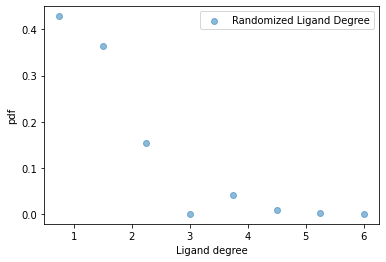

In [41]:
count, bins_count = np.histogram(randomized_ligand_degrees,bins=8)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.scatter(bins_count[1:],pdf, label="Randomized Ligand Degree",alpha=0.5)

plt.legend()
plt.xlabel('Ligand degree')
plt.ylabel('pdf')
plt.show()

In [42]:
randomized_target_degrees = []

for node_tar in bottom_nodes:
    randomized_target_degrees.append(layer1_randomized.degree(node_tar))

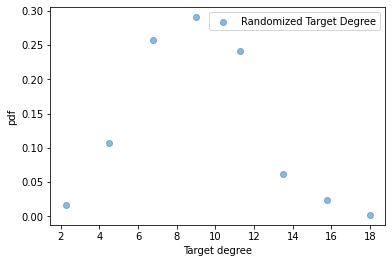

In [45]:
count, bins_count = np.histogram(randomized_target_degrees,bins=8)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.scatter(bins_count[1:],pdf, label="Randomized Target Degree",alpha=0.5)

plt.legend()
plt.xlabel('Target degree')
plt.ylabel('pdf')
plt.show()

# Randomizing Layer 2

In [46]:
randomized_ligand_degrees_negative = [len(bottom_nodes) - i for i in randomized_ligand_degrees]

randomized_target_degrees_negative = [len(top_nodes) - i for i in randomized_target_degrees]

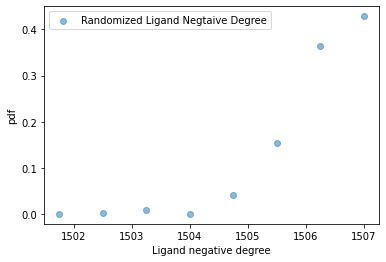

In [48]:
count, bins_count = np.histogram(randomized_ligand_degrees_negative,bins=8)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.scatter(bins_count[1:],pdf, label="Randomized Ligand Negtaive Degree",alpha=0.5)

plt.legend()
plt.xlabel('Ligand negative degree')
plt.ylabel('pdf')
plt.show()

In [155]:
stats.spearmanr(randomized_ligand_degrees, randomized_ligand_degrees_negative)

SpearmanrResult(correlation=-1.0, pvalue=0.0)

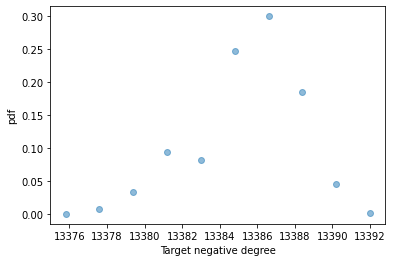

In [51]:
count, bins_count = np.histogram(randomized_target_degrees_negative,bins=10)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.scatter(bins_count[1:],pdf, label="Randomized Target Negtaive Degree",alpha=0.5)

# plt.legend()
plt.xlabel('Target negative degree')
plt.ylabel('pdf')
plt.show()

In [156]:
stats.spearmanr(randomized_target_degrees, randomized_target_degrees_negative)

SpearmanrResult(correlation=-1.0, pvalue=0.0)

In [53]:
layer2 = bipartite.configuration_model(randomized_ligand_degrees_negative, randomized_target_degrees_negative, create_using=nx.Graph())

In [54]:
bipartite.is_bipartite(layer2)

True

In [55]:
layer2.number_of_edges()

12754422

In [57]:
top_nodes = {n for n, d in layer2.nodes(data=True) if d["bipartite"] == 0}

len(top_nodes)

13392

In [59]:
bottom_nodes = set(layer2) - top_nodes

len(bottom_nodes)

1507

# Creating DataFrame

In [62]:
randomized_samples = pd.DataFrame()

SMILE_list = []
target_aa_code_list = []

#desired_positive_edge = int(len(list(layers_randomized.edges())) * positive_edge_count/(positive_edge_count + negative_edge_count))
#desired_negative_edge = len(list(layers_randomized.edges())) - desired_positive_edge

for edge in list(layer1_randomized.edges()):
    SMILE_list.append(ligands[edge[0]])
    target_aa_code_list.append(targets[edge[1]-len(ligands)]) ## bottom nodes indexing starts from len(ligands)
    
for edge in list(layer2.edges()):
    SMILE_list.append(ligands[edge[0]])
    target_aa_code_list.append(targets[edge[1]-len(ligands)]) ## bottom nodes indexing starts from len(ligands)
        
randomized_samples['SMILE'] = SMILE_list
randomized_samples['target_aa_code'] = target_aa_code_list
randomized_samples['Y'] = [1] * len(layer1_randomized.edges()) + [0] * len(layer2.edges())

In [63]:
len(randomized_samples[randomized_samples['Y'] == 1]) 

11326

In [64]:
len(randomized_samples[randomized_samples['Y'] == 0]) 

12754422

# Degree Ratio Distributions

In [66]:
ligand_degree_ratio_randomized = [randomized_ligand_degrees[i] / (randomized_ligand_degrees[i] + randomized_ligand_degrees_negative[i]) for i in range(len(ligands))]

target_degree_ratio_randomized = [randomized_target_degrees[i] / (randomized_target_degrees[i] + randomized_target_degrees_negative[i]) for i in range(len(targets))]


(array([5.741e+03, 4.876e+03, 0.000e+00, 2.074e+03, 0.000e+00, 5.410e+02,
        1.250e+02, 0.000e+00, 3.100e+01, 4.000e+00]),
 array([0.        , 0.00039814, 0.00079628, 0.00119443, 0.00159257,
        0.00199071, 0.00238885, 0.00278699, 0.00318514, 0.00358328,
        0.00398142]),
 <a list of 10 Patch objects>)

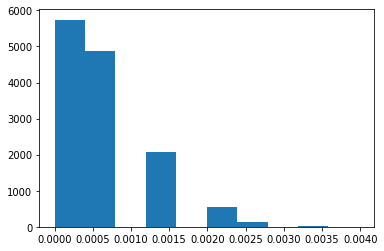

In [67]:
plt.hist(ligand_degree_ratio_randomized)

(array([  3.,  69., 280., 452., 208., 288., 142.,  52.,  12.,   1.]),
 array([0.        , 0.00013441, 0.00026882, 0.00040323, 0.00053763,
        0.00067204, 0.00080645, 0.00094086, 0.00107527, 0.00120968,
        0.00134409]),
 <a list of 10 Patch objects>)

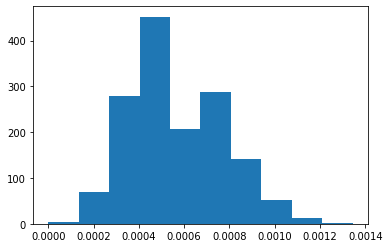

In [69]:
plt.hist(target_degree_ratio_randomized)

# BindingDB Degree Ratios

In [70]:
ligand_pos_degree = []
ligand_neg_degree = []
ligand_degree_ratio_bindingDB = []

for chem in tqdm(set(all_data['SMILES'].tolist())):
    sub_df = all_data[all_data['SMILES'] == chem]
    ligand_pos_degree.append(sub_df['Label'].tolist().count(1))
    ligand_neg_degree.append(sub_df['Label'].tolist().count(0))
    ligand_degree_ratio_bindingDB.append(sub_df['Label'].tolist().count(1)/(sub_df['Label'].tolist().count(1)+sub_df['Label'].tolist().count(0)))

100%|██████████| 13392/13392 [01:51<00:00, 119.64it/s]


In [71]:
target_pos_degree = []
target_neg_degree = []
target_degree_ratio_bindingDB = []

for prot in tqdm(set(all_data['Target Sequence'].tolist())):
    sub_df = all_data[all_data['Target Sequence'] == prot]
    target_pos_degree.append(sub_df['Label'].tolist().count(1))
    target_neg_degree.append(sub_df['Label'].tolist().count(0))
    target_degree_ratio_bindingDB.append(sub_df['Label'].tolist().count(1)/(sub_df['Label'].tolist().count(1)+sub_df['Label'].tolist().count(0)))

100%|██████████| 1507/1507 [00:12<00:00, 119.26it/s]


# Degree Ratio with Both Layers Separately Randomized

(array([6.22685185, 0.03733572, 0.13814217, 0.08885902, 0.03584229,
        0.38306452, 0.08213859, 0.02165472, 0.01717443, 2.96893668]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

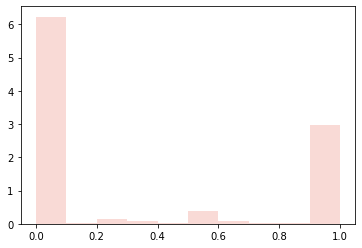

In [74]:
plt.hist(ligand_degree_ratio_bindingDB, label='Original data',alpha=0.2,density=True, color='#e34a33')

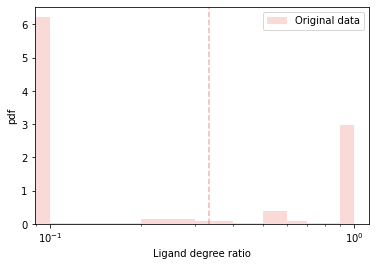

In [76]:
#plt.hist(ligand_degree_ratio_randomized,label='Randomized Layers',alpha=0.2,density=True)
plt.hist(ligand_degree_ratio_bindingDB, label='Original data',alpha=0.2,density=True, color='#e34a33')
plt.axvline(x = np.mean(ligand_degree_ratio_bindingDB), linestyle='--', alpha=0.4, color='#e34a33')

plt.xscale('log')
plt.xlabel('Ligand degree ratio')
plt.ylabel('pdf')
plt.legend()
plt.show()

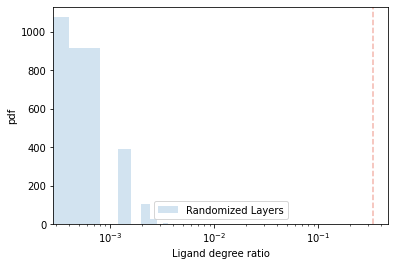

In [79]:
plt.hist(ligand_degree_ratio_randomized,label='Randomized Layers',alpha=0.2,density=True)
#plt.hist(ligand_degree_ratio_bindingDB, label='Original data',alpha=0.2,density=True, color='#e34a33')
plt.axvline(x = np.mean(ligand_degree_ratio_bindingDB), linestyle='--', alpha=0.4, color='#e34a33')

plt.xscale('log')
plt.xlabel('Ligand degree ratio')
plt.ylabel('pdf')
plt.legend()
plt.show()

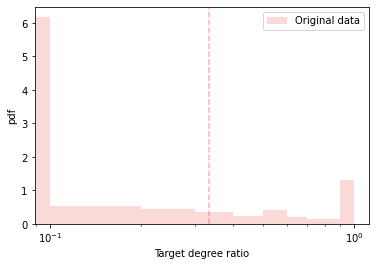

In [83]:
#plt.hist(target_degree_ratio_randomized,label='Randomized Layers',alpha=0.2,density=True)
plt.hist(target_degree_ratio_bindingDB, label='Original data',alpha=0.2,density=True, color='#e34a33')
plt.axvline(x = np.mean(ligand_degree_ratio_bindingDB), linestyle='--', alpha=0.4, color='#e34a33')

plt.xscale('log')
plt.legend()
plt.xlabel('Target degree ratio')
plt.ylabel('pdf')
plt.show()

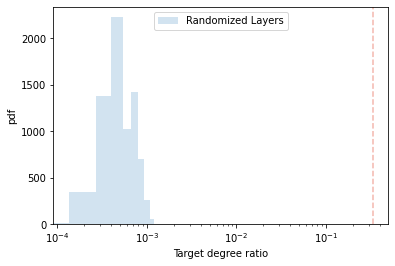

In [84]:
plt.hist(target_degree_ratio_randomized,label='Randomized Layers',alpha=0.2,density=True)
#plt.hist(target_degree_ratio_bindingDB, label='Original data',alpha=0.2,density=True, color='#e34a33')
plt.axvline(x = np.mean(ligand_degree_ratio_bindingDB), linestyle='--', alpha=0.4, color='#e34a33')

plt.xscale('log')
plt.legend()
plt.xlabel('Target degree ratio')
plt.ylabel('pdf')
plt.show()

# Generating the Negatives from rho Distribution 

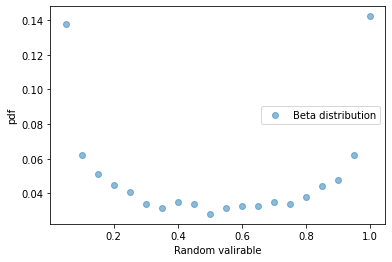

In [59]:
beta_test_list = []

for i in range(10000):
    beta_test_list.append(np.random.beta(a=0.5, b=0.5))
    
count, bins_count = np.histogram(beta_test_list,bins=20)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.scatter(bins_count[1:],pdf, label="Beta distribution",alpha=0.5)

plt.legend()
plt.xlabel('Random valirable')
plt.ylabel('pdf')
plt.show()

In [150]:
randomized_ligand_negative_degrees = []

for k_plus in randomized_ligand_degrees:
    rho_i = np.random.beta(a=0.5, b=0.5)
    randomized_ligand_negative_degrees.append(int(k_plus*(1-rho_i)/rho_i))
       

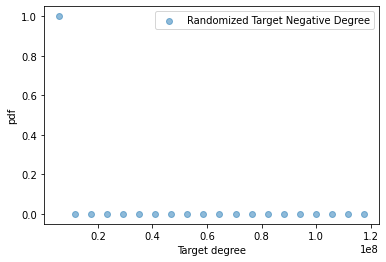

In [151]:
count, bins_count = np.histogram(randomized_ligand_negative_degrees,bins=20)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.scatter(bins_count[1:],pdf, label="Randomized Target Negative Degree",alpha=0.5)

plt.legend()
plt.xlabel('Target degree')
plt.ylabel('pdf')
plt.show()

In [152]:
randomized_target_negative_degrees = []

for k_plus in randomized_target_degrees:
    rho_i = np.random.beta(a=0.5, b=0.5)
    randomized_target_negative_degrees.append(int(k_plus*(1-rho_i)/rho_i))
    
randomized_target_negative_degrees_original = randomized_target_negative_degrees
    
## Normalization 
#randomized_target_negative_degrees_normalized = [x/sum(randomized_target_negative_degrees) for x in randomized_target_negative_degrees]

## Create sequence so that the sum of both sequences are the same
#randomized_target_negative_degrees = [x*sum(randomized_ligand_negative_degrees) for x in randomized_target_negative_degrees_normalized]

In [153]:
sum(randomized_target_negative_degrees)

27958484

In [154]:
sum(randomized_ligand_negative_degrees)

160092637

In [155]:
if sum(randomized_target_negative_degrees) > sum(randomized_ligand_negative_degrees):
    while sum(randomized_target_negative_degrees) != sum(randomized_ligand_negative_degrees):
        random_index = np.random.randint(len(randomized_target_negative_degrees))
        randomized_target_negative_degrees[random_index] = randomized_target_negative_degrees[random_index]  - 1
        
elif sum(randomized_target_negative_degrees) < sum(randomized_ligand_negative_degrees):
    while sum(randomized_target_negative_degrees) != sum(randomized_ligand_negative_degrees):
        random_index = np.random.randint(len(randomized_target_negative_degrees))
        randomized_target_negative_degrees[random_index] = randomized_target_negative_degrees[random_index]  + 1

KeyboardInterrupt: 

In [ ]:
count, bins_count = np.histogram(randomized_target_negative_degrees_original,bins=15)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.scatter(bins_count[1:],pdf, label="Original",alpha=0.4,marker='x')

count, bins_count = np.histogram(randomized_target_negative_degrees,bins=15)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.scatter(bins_count[1:],pdf, label="Adjusted",alpha=0.4,marker='o')

plt.legend()
plt.xlabel('Randomized Target Negative Degree')
plt.ylabel('pdf')
plt.show()

In [131]:
layer2_randomized = bipartite.configuration_model(randomized_ligand_negative_degrees,randomized_target_negative_degrees,create_using=nx.Graph())

In [132]:
bipartite.is_bipartite(layer2_randomized)

True

In [133]:
top_nodes = {n for n, d in layer2_randomized.nodes(data=True) if d["bipartite"] == 0}

In [134]:
len(top_nodes) ## These are ligands

6480

In [135]:
bottom_nodes = set(layer2_randomized) - top_nodes

In [136]:
len(bottom_nodes) ## These are targets

3970

# Duplex Configuration Model

In [85]:
randomized_samples

,SMILE,target_aa_code,Y
0,C(CN1CCN(CCN(Cc2ccccc2)c2ccccc2)CC1)Cc1ccccc1,MVSSQKLEKPIEMGSSEPLPIADGDRRRKKKRRGRATDSLPGKFED...,1
1,C(CN1CCN(CCN(Cc2ccccc2)c2ccccc2)CC1)Cc1ccccc1,MKANLLVLLCALAAADADTICIGYHANNSTDTVDTVLEKNVTVTHS...,1
2,CN(C1CCCCC1)c1ncnc2[nH]ccc12,MDSPIQIFRGEPGPTCAPSACLPPNSSAWFPGWAEPDSNGSAGSED...,1
3,CN(C1CCCCC1)c1ncnc2[nH]ccc12,MYDAIVVGGGFSGLKAARDLTNAGKKVLLLEGGERLGGRAYSRESR...,1
4,CNc1cc(Nc2cccn(C3CC(F)(F)C3)c2=O)nc2c(cnn12)C(...,NPPPPETSNPNKPKRQTNQLQYLLRVVLKTLWKHQFAWPFQQPVDA...,1
...,...,...,...
12765743,CCC(C)NC(=O)c1cccc(Cc2cc(Cl)ccc2OCc2ccc(Cl)cc2...,MSVGCPEPEPPRSLTCCGPGTAPGPGAGVPLLTEDMQALTLRTLAA...,0
12765744,CCC(C)NC(=O)c1cccc(Cc2cc(Cl)ccc2OCc2ccc(Cl)cc2...,MVNLGNAVRSLLMHLIGLLVWQFDISISPVAAIVTDTFNSSDGGRL...,0
12765745,CCC(C)NC(=O)c1cccc(Cc2cc(Cl)ccc2OCc2ccc(Cl)cc2...,MGKSNSKLKPEVVEELTRKTYFTEKEVQQWYKGFIKDCPSGQLDAA...,0
12765746,CCC(C)NC(=O)c1cccc(Cc2cc(Cl)ccc2OCc2ccc(Cl)cc2...,MSTMRLLTLALLFSCSVARAACDPKIVNIGAVLSTRKHEQMFREAV...,0


In [96]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(randomized_samples, test_size=0.3)

In [144]:
train.to_csv('../data/original_rho/train.csv')
test.to_csv('../data/original_rho/test.csv')

In [142]:
ligands_degree_dict = dict()

for smile_chem in tqdm(ligands):
    sum_df = train[train['SMILE'] == smile_chem]
    ligands_degree_dict[smile_chem] = dict()
    ligands_degree_dict[smile_chem]['deg_0'] = len(sum_df[sum_df['Y'] == 0])
    ligands_degree_dict[smile_chem]['deg_1'] = len(sum_df[sum_df['Y'] == 1])
    
targets_degree_dict = dict()

for aa_target in tqdm(targets):
    sum_df = train[train['target_aa_code'] == aa_target]
    targets_degree_dict[aa_target] = dict()
    targets_degree_dict[aa_target]['deg_0'] = len(sum_df[sum_df['Y'] == 0])
    targets_degree_dict[aa_target]['deg_1'] = len(sum_df[sum_df['Y'] == 1])
    
degree_train_1_0_ligands = [ligands_degree_dict[key_val]['deg_1'] for key_val in tqdm(ligands_degree_dict.keys())]
degree_train_0_1_ligands = [ligands_degree_dict[key_val]['deg_0'] for key_val in tqdm(ligands_degree_dict.keys())]

degree_train_1_0_targets = [targets_degree_dict[key_val]['deg_1'] for key_val in tqdm(targets_degree_dict.keys())]
degree_train_0_1_targets = [targets_degree_dict[key_val]['deg_0'] for key_val in tqdm(targets_degree_dict.keys())]

100%|██████████| 1507/1507 [00:00<00:00, 1094324.12it/s]


In [143]:
with open('../data/original_rho/degreetrain10ligands.txt', 'w') as file:
    for degree in degree_train_1_0_ligands:
        file.write("%i\n" % degree)
        
file.close()

with open('../data/original_rho/degreetrain01ligands.txt', 'w') as file:
    for degree in degree_train_0_1_ligands:
        file.write("%i\n" % degree)
        
file.close()

with open('../data/original_rho/degreetrain10targets.txt', 'w') as file:
    for degree in degree_train_1_0_targets:
        file.write("%i\n" % degree)
        
file.close()

with open('../data/original_rho/degreetrain01targets.txt', 'w') as file:
    for degree in degree_train_0_1_targets:
        file.write("%i\n" % degree)
        
file.close()

textfile = open("../data/original_rho/ligands.txt", "w")
for element in ligands:
    textfile.write(element + "\n")
textfile.close()

textfile = open("../data/original_rho/targets.txt", "w")
for element in targets:
    textfile.write(element + "\n")
textfile.close()

In [145]:
summat10 = np.loadtxt(open("../data/original_rho/summat10.csv", "rb"), delimiter=",", skiprows=0) # Output of MATLAB run
summat01 = np.loadtxt(open("../data/original_rho/summat01.csv", "rb"), delimiter=",", skiprows=0) # Output of MATLAB run 

In [147]:
train_pos = train[train['Y'] == 1]
train_neg = train[train['Y'] == 0]

pos_deg_0_ligands = []
pos_deg_0_targets = []
neg_deg_0_ligands = []
neg_deg_0_targets = []

ligand_degree_ratio = dict()
ligand_all_average = []

for ligand in tqdm(ligands):
    pos_deg = ligands_degree_dict[ligand]['deg_1']
    neg_deg = ligands_degree_dict[ligand]['deg_0']
    if pos_deg + neg_deg != 0:
        ligand_degree_ratio[ligand] = dict()
        ligand_degree_ratio[ligand]['deg_ratio'] = pos_deg / (pos_deg + neg_deg)
        ligand_degree_ratio[ligand]['deg_avg'] = pos_deg / len(targets) 
        ligand_all_average.append(pos_deg / len(targets))
    if pos_deg == 0:
        pos_deg_0_ligands.append(ligand)
    if neg_deg == 0:
        neg_deg_0_ligands.append(ligand)
    
ligands_all_avg = sum(ligand_all_average) / len(ligands)

targets_degree_ratio = dict()
target_all_average = []

for target in tqdm(targets):
    pos_deg = targets_degree_dict[target]['deg_1']
    neg_deg = targets_degree_dict[target]['deg_0']
    if pos_deg + neg_deg != 0:
        targets_degree_ratio[target] = dict()
        targets_degree_ratio[target]['deg_ratio'] = pos_deg / (pos_deg + neg_deg)
        targets_degree_ratio[target]['deg_avg'] = pos_deg / len(ligands)
        target_all_average.append(pos_deg / len(ligands))
    if pos_deg == 0:
        pos_deg_0_targets.append(target)
    if neg_deg == 0:
        neg_deg_0_targets.append(target)
    
targets_all_avg = sum(target_all_average) / len(targets)

100%|██████████| 1507/1507 [00:00<00:00, 356664.94it/s]


In [148]:
## Annotated means the node has at least 1 binding information

pos_annotated_ligands = list(set(ligands)-set(pos_deg_0_ligands))
pos_annotated_targets = list(set(targets)-set(pos_deg_0_targets))

neg_annotated_ligands = list(set(ligands)-set(neg_deg_0_ligands))
neg_annotated_targets = list(set(targets)-set(neg_deg_0_targets))

In [149]:
test_probabilty_predicted_conditioned = []

## Average conditional probability
p10_avg = np.mean(summat10)
p01_avg = np.mean(summat01)
average_conditional_probability = p10_avg / (p10_avg + p01_avg)

for index, row in tqdm(test.iterrows()):      
    
    if row['SMILE'] in pos_annotated_ligands and row['target_aa_code'] in pos_annotated_targets:
        p10 = summat10[ligands.index(row['SMILE']),targets.index(row['target_aa_code'])]
        p01 = summat01[ligands.index(row['SMILE']),targets.index(row['target_aa_code'])]
        p10_conditioned = p10 / (p10 + p01)
        test_probabilty_predicted_conditioned.append(p10_conditioned)
        
    elif row['SMILE'] in pos_annotated_ligands and row['target_aa_code'] not in pos_annotated_targets:
        p10_conditioned = ligand_degree_ratio[row['SMILE']]['deg_ratio']  ## k_+ / (k_+ + k_-)
        test_probabilty_predicted_conditioned.append(p10_conditioned)
        
    elif row['SMILE'] not in pos_annotated_ligands and row['target_aa_code'] in pos_annotated_targets:
        p10_conditioned = targets_degree_ratio[row['target_aa_code']]['deg_ratio'] ## k_+ / (k_+ + k_-)
        test_probabilty_predicted_conditioned.append(p10_conditioned)

    else:
        p10_conditioned = average_conditional_probability
        test_probabilty_predicted_conditioned.append(p10_conditioned)
        

3829725it [33:03, 1931.16it/s]


In [152]:
## Performance on the test dataset

print('AUC: ', roc_auc_score(test['Y'].tolist(), test_probabilty_predicted_conditioned))
print('AUP: ', average_precision_score(test['Y'].tolist(), test_probabilty_predicted_conditioned))

AUC:  0.4962187716694196
AUP:  0.0008934112192457443


In [153]:
test['test_probabilty_predicted_conditioned'] = test_probabilty_predicted_conditioned

train_ligands = list(set(train['SMILE'].tolist()))
train_targets = list(set(train['target_aa_code'].tolist()))

test_minus_train_ligands = list(set(test['SMILE'].tolist()).difference(train_ligands))
test_minus_train_targets = list(set(test['target_aa_code'].tolist()).difference(train_targets))

print('Seen ligands: ', len(train_ligands))
print('Seen targets: ', len(train_targets))
print('Unseen ligands: ', len(test_minus_train_ligands))
print('Unseen targets: ', len(test_minus_train_targets))

/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Seen ligands:  13392
Seen targets:  1507
Unseen ligands:  0
Unseen targets:  0
